## Installation of dependencies

In [73]:
!pip install python-binance
!pip install stockstats
!pip install scipy
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 11.3 MB/s eta 0:00:0000:0100:01
  Using cached kiwisolver-1.4.4-cp39-cp39-macosx_11_0_arm64.whl (63 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.5-cp39-cp39-macosx_11_0_arm64.whl (226 kB)
  Using cached fonttools-4.37.4-py3-none-any.whl (960 kB)
  Using cached Pillow-9.2.0-cp39-cp39-macosx_11_0_arm64.whl (2.8 MB)


## Initialize Binance client

You need to provide your API key and API secret to initialize the Binance client instance. It also should be noted having keys and secrets inside of your repository is of course not a good practice in terms of the security of your account.

It is good practice to have this type of sensitive information in environment variables. For more detailed information you can check the below article.
https://networkdirection.net/python/resources/env-variable/

But since this tutorial only cares about getting things done, I will use keys in my code directly. 


In [52]:
from binance import Client

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stockstats import wrap, unwrap
from scipy import interpolate

api_key = "** YOUR API KEY GOES HERE ** "
api_secret = "** YOUR API SECRET GOES HERE **"

client = Client(api_key, api_secret)

### Checking the connection
Let's check whether our client instance working properly. According to python-binance  documentation, status should be 0 and msg should be 'normal'.

In [2]:
status = client.get_system_status()
status

{'status': 0, 'msg': 'normal'}

### Fetching the prices

Client class has a really nice method called 'get_historical_klines' for fetching the prices. It looks like a simple wrapper around the API call, however, it sends multiple requests to Binance API and aggregates the responses to fetch more than 500 data points when it is needed. Because Binance API only allows us to request 500 data points at one time. And another thing that I like about this function is the format flexibility of datetime arguments.

**BTCUSDT** symbol prices started from 3 months ago will be fetched in 1 Hour intervals.

In [3]:
btcusdt_raw = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "90 day ago UTC")

### Converting the prices into pandas.DataFrame

Unfortunately, price data is not received in our favorite format, which is pandas.DataFrame. We need to translate it into DataFrame first. I set the column names according to Binance API documentation.

In [4]:
btcusdt = pd.DataFrame(btcusdt_raw,
                       dtype='float',
                       columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 
                                'close_time', 'quote_volume', 'trade_count', 'taker_buy_vol', 
                                'taker_buy_quote_vol', 'unused'])

btcusdt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   open_time            2160 non-null   float64
 1   open                 2160 non-null   float64
 2   high                 2160 non-null   float64
 3   low                  2160 non-null   float64
 4   close                2160 non-null   float64
 5   volume               2160 non-null   float64
 6   close_time           2160 non-null   float64
 7   quote_volume         2160 non-null   float64
 8   trade_count          2160 non-null   float64
 9   taker_buy_vol        2160 non-null   float64
 10  taker_buy_quote_vol  2160 non-null   float64
 11  unused               2160 non-null   float64
dtypes: float64(12)
memory usage: 202.6 KB


### Post processing DataFrame

Even though we got the price data in our best data structure format, it still needs some polishing before we continue.

First, we need to convert epoch timestamps to datetime objects to set this as TimeIndex to our data frame. This operation is done by the 'pandas.to_datetime' function. the unit argument is set as 'ms' as Binance API timestamps in the 'ms'.

The second operation is just dropping the columns that we don't need. However, this step is application specific. I also removed the 'volume' column because it is the volume in terms of base asset, in this case in BTC. What we usually want to see as volume is the quote asset, which is USDT in this case. Therefore, I removed the 'volume' column and renamed back 'quote_volume' as 'volume'.

And lastly, I set the 'time' column as an index to our data frame.

In [5]:
btcusdt['time'] = pd.to_datetime(btcusdt['open_time'], unit='ms')


btcusdt.drop(columns=['open_time', 'close_time', 'taker_buy_vol', 
                      'taker_buy_quote_vol', 'volume', 'trade_count', 'unused'], 
             inplace= True) # drop the unnecessary columns.

btcusdt.rename(columns={'quote_volume':'volume'}, inplace=True)

btcusdt.set_index('time', inplace=True)

btcusdt.head()

,open,high,low,close,volume
time,,,,,
2022-07-19 07:00:00,21760.43,21880.97,21687.24,21764.88,1.849770e+08
2022-07-19 08:00:00,21764.88,21937.04,21696.60,21922.08,1.547298e+08
2022-07-19 09:00:00,21922.08,21969.80,21805.67,21905.75,1.196610e+08
2022-07-19 10:00:00,21903.36,22113.23,21810.00,22004.92,1.661148e+08
2022-07-19 11:00:00,22002.01,22230.00,21909.00,21974.49,1.938769e+08


### Plotting BTCUSDT

Finally we can plot the close prices. How volatile the prices are in the last months, huh.

<AxesSubplot: xlabel='time'>

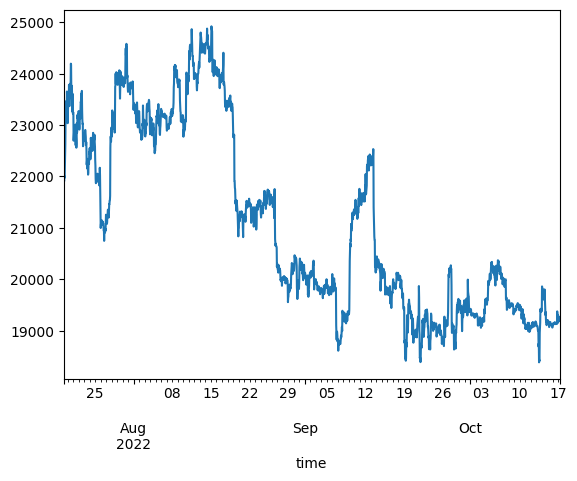

In [6]:
btcusdt['close'].plot()

### Resampling the financial data

Resampling the financial time series data is one of the crucial steps that we need frequently. Although we don't need it yet, in the next chapter of this series we are going to use price data with different time intervals. I decided to put **resample** function here as it is more related to price data processing.


In [7]:
def resample(stock_price_df, new_period, offset=0):
    ohlc = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }

    return stock_price_df.resample(new_period, offset).apply(ohlc)

In [8]:
btcusdt_4h = resample(btcusdt, '4H')
btcusdt_12h = resample(btcusdt, '12H')

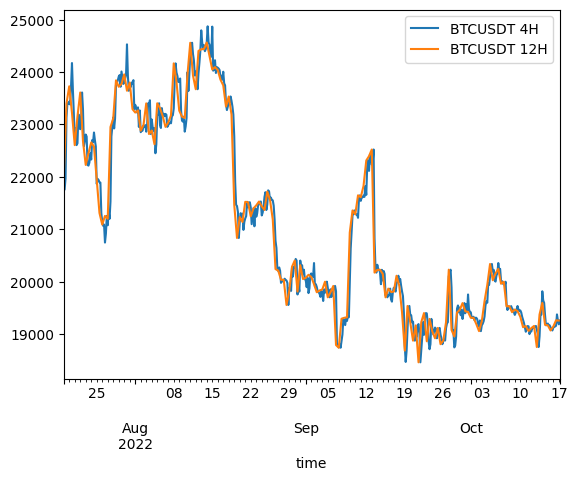

In [9]:
fig, ax = plt.subplots()

btcusdt_4h['close'].plot(ax=ax)
btcusdt_12h['close'].plot(ax=ax)
ax.legend(['BTCUSDT 4H', 'BTCUSDT 12H'])

### Calculating EMA indicators

As I explained at the very beginning of this article we will use the stockstats library to calculate EMA indicators. stockstats is a library based on the pandas DataFrames but provides an incredibly well-thought protocol to calculate indicator values lazily, all you need to do is comply with the format below.

price_data_df[{candle_part}_{args}_{indicator_name}]

For example, if you want to get EMA of close prices with a period of 16 you can easily access them via the **close_16_ema** column name.

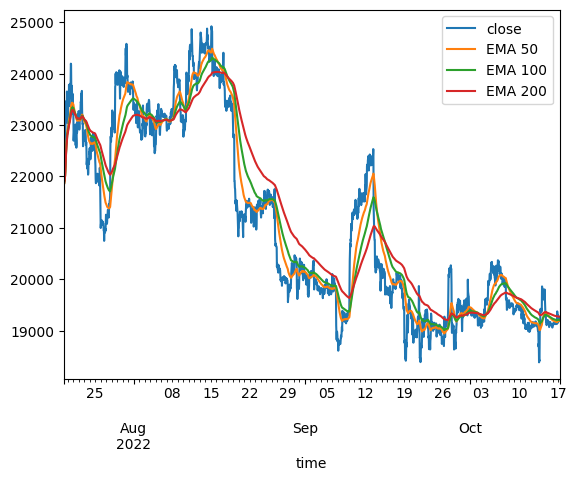

In [10]:
btcusdt = wrap(btcusdt)

fig, ax = plt.subplots()

btcusdt['close'].plot(ax=ax)
btcusdt['close_50_ema'].plot(ax=ax)
btcusdt['close_100_ema'].plot(ax=ax)
btcusdt['close_200_ema'].plot(ax=ax)

ax.legend(['close', 'EMA 50', 'EMA 100', 'EMA 200'])


### B-Spline fitting


All up to this point is the preparation phase for getting us ready for the most important and fun step. I hope you have not lost your will and you can pay attention to the rest.
Splines are one of the piecewise, non-linear regression interfaces which are used in engineering applications frequently. They don't bear the disadvantages of polynomial regressions such as overfitting and instability and yet they are continuous between the pieces. Doesn't it sound great? 
Piecewise regressions are fundamentally polynomial regressions but data is split into multiple regions via knots and each region between the knots is fit with local basis functions instead of fitting whole data with global functions. If continuity and smoothness constraints are applied to these local functions you can craft splines. 
The reason I have chosen B-splines is that basis functions are quite local and any changes in the controlling points only affect the curve of this corresponding segment.

---

Even though it is quite a challenging mathematical method, it is only a few lines of code with a great Scipy package. There is only one function and one class that we need to grasp every detail about them. interpolate.splrep and interpolate.BSpline. In essence, splrep is used for calculating coefficients of b-splines from 1-D curves, whereas BSpline is a class for constructing b-splines from coefficients. 


The most important point here to comprehend is that knot positions will be defined by us, instead of letting the splrep calculate the best knot positions. Because it won't be possible to calculate the similarity between different time series based on their B-splines if their knot positions are different ( small displacements are actually okay, but let's stay safe ). Letting the splrep do that will give different knot positions for time series data that are behaving differently. Therefore we will subsample the time axis in a 1:96 ( 1 data point in 4 days) ratio to use as fixed knot positions.

For now, I will use only close_25_ema values for fitting for sake of simplicity.  We can easily calculate knot positions and then B-spline coefficients as follows;

In [120]:
PADDING = 12
SR = 72

x_axis = np.arange(0, len(btcusdt.index))
knot_positions = np.arange(PADDING, len(btcusdt.index) - PADDING, SR)

coefficients = interpolate.splrep(x_axis, btcusdt['close_25_ema'], t=knot_positions, k=5)
bspline_fit = interpolate.BSpline(*coefficients)(x_axis)

In [121]:
coefficients

(array([   0.,    0.,    0.,    0.,    0.,    0.,   12.,   84.,  156.,
         228.,  300.,  372.,  444.,  516.,  588.,  660.,  732.,  804.,
         876.,  948., 1020., 1092., 1164., 1236., 1308., 1380., 1452.,
        1524., 1596., 1668., 1740., 1812., 1884., 1956., 2028., 2100.,
        2159., 2159., 2159., 2159., 2159., 2159.]),
 array([22036.34896647, 21126.26369629, 25340.07933897, 20599.53787631,
        26542.98719459, 18167.51713156, 23926.94960368, 24677.94133414,
        21783.45087684, 23902.06296999, 22763.98968062, 24854.87005894,
        24170.55521205, 24446.88834367, 18626.99446856, 23964.32135763,
        18875.70494615, 20858.31245715, 19211.9353354 , 21184.40691906,
        16358.00613287, 25398.34578634, 18762.43138904, 20638.5178146 ,
        18480.59362868, 19406.17921141, 18551.1582864 , 20369.73525318,
        18051.96551991, 21226.61525589, 19082.60201875, 19437.03972841,
        18628.34816331, 19944.35121733, 18686.90479652, 19364.63002034,
            0.  

Yikes! It is done. Let's explore what our B-splines look like;

(array([19188., 19205., 19219., 19236., 19250., 19266., 19280.]),
 [Text(19188.0, 0, '2022-07-15'),
  Text(19205.0, 0, '2022-08-01'),
  Text(19219.0, 0, '2022-08-15'),
  Text(19236.0, 0, '2022-09-01'),
  Text(19250.0, 0, '2022-09-15'),
  Text(19266.0, 0, '2022-10-01'),
  Text(19280.0, 0, '2022-10-15')])

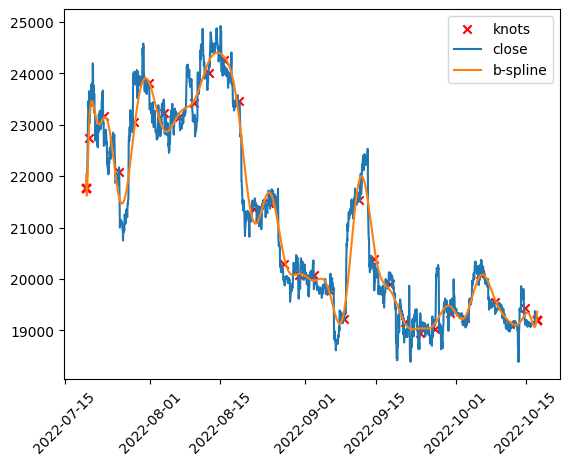

In [129]:
fig, ax = plt.subplots()

ax.scatter(btcusdt.iloc[coefficients[0]].index, 
           btcusdt.iloc[coefficients[0]]['close_25_ema'], 
           marker='x', 
           color='r')

ax.plot(btcusdt['close'])
ax.plot(btcusdt.index, bspline_fit)

ax.legend(['knots', 'close', 'b-spline'])
plt.xticks(rotation=45)


Great! It looks like we successfully reduce a huge amount of data but still have a grasp of its high-level dynamics. The original data set has 2160 data points where we can just use 36 b-spline coefficients to represent it which is %1.2, as the knots are fixed.

## Conclusion
As can be observed from the graph, B-splines provide great fitting performance even though knot positions are subsampled in a 1:72 ratio. That amount of data reduction of course comes with some local fitting errors which need to be addressed as well.